# Event classifier

In [103]:
%matplotlib inline
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

import warnings; warnings.simplefilter('ignore')

seed = 42

In [104]:
df = pd.read_excel('table_results_complete.xlsx')
df.head()

original filename           filename   ID    label  \
0  L014752P000136T1525948500W0109F3300.dat  neutral_12609.mat  205  neutral   
1  L014752P007119T1525947183W0112F3300.dat    train_24150.mat  366    train   
2  L014752P007084T1521118686W0136F3300.dat    train_23280.mat  358    train   
3  L014752P007706T1525947134W0126F3300.dat    train_33300.mat  455    train   
4  L014752P007883T1525948600W0150F3300.dat    train_35390.mat  478    train   

   10th percentile of 1. cepstral mean subtraction coeff.  \
0                                          -0.982736        
1                                          -1.286113        
2                                          -1.317864        
3                                          -0.866460        
4                                          -1.498598        

   10th percentile of 1. delta coeff. of cepstral mean subtraction coeff.  \
0                                          -0.234930                        
1                                          -0.121870                        
2                                          -0.195586                        
3                                          -0.111458                        
4                                          -0.202176                        

   10th percentile of 1. delta coeff. of linear frequency cepstral coefficients  \
0                                          -0.492827                              
1                                          -0.281532                              
2                                          -0.154806                              
3                                          -0.248059                              
4                                          -0.427680                              

   10th percentile of 1. delta coeff. of linear predictive cepstral coefficients  \
0                                          -0.047105                               
1                                          -0.064703                               
2                                          -0.026315                               
3                                          -0.029780                               
4                                          -0.019005                               

   10th percentile of 1. delta coeff. of mel frequency cepstral coefficients  \
0                                          -0.492827                           
1                                          -0.281532                           
2                                          -0.154806                           
3                                          -0.248059                           
4                                          -0.427680                           

   10th percentile of 1. linear frequency cepstral coefficients  \
0                                           3.964777              
1                                          -0.855625              
2                                           5.331015              
3                                           5.662880              
4                                           0.498028              

           ...           \
0          ...            
1          ...            
2          ...            
3          ...            
4          ...            

   var of 9. delta coeff. of linear frequency cepstral coefficients  \
0                                           0.005896                  
1                                           0.005329                  
2                                           0.007824                  
3                                           0.007974                  
4                                           0.004030                  

   var of 9. delta coeff. of mel frequency cepstral coefficients  \
0                                           0.012696               
1                                           0.004671               
2                                     

In [105]:
df['label'].value_counts().plot(kind='bar', rot=0)
plt.savefig('output/class_counts_unprocessed.pdf')
plt.savefig('output/class_counts_unprocessed.png')

In [106]:
lab_to_int = {'neutral': 0, 'crossing': 0, 'train': 1}
int_to_lab = {value: key for key, value in lab_to_int.items()}

df = df.replace(lab_to_int)
df.head()

original filename           filename   ID  label  \
0  L014752P000136T1525948500W0109F3300.dat  neutral_12609.mat  205      0   
1  L014752P007119T1525947183W0112F3300.dat    train_24150.mat  366      1   
2  L014752P007084T1521118686W0136F3300.dat    train_23280.mat  358      1   
3  L014752P007706T1525947134W0126F3300.dat    train_33300.mat  455      1   
4  L014752P007883T1525948600W0150F3300.dat    train_35390.mat  478      1   

   10th percentile of 1. cepstral mean subtraction coeff.  \
0                                          -0.982736        
1                                          -1.286113        
2                                          -1.317864        
3                                          -0.866460        
4                                          -1.498598        

   10th percentile of 1. delta coeff. of cepstral mean subtraction coeff.  \
0                                          -0.234930                        
1                                          -0.121870                        
2                                          -0.195586                        
3                                          -0.111458                        
4                                          -0.202176                        

   10th percentile of 1. delta coeff. of linear frequency cepstral coefficients  \
0                                          -0.492827                              
1                                          -0.281532                              
2                                          -0.154806                              
3                                          -0.248059                              
4                                          -0.427680                              

   10th percentile of 1. delta coeff. of linear predictive cepstral coefficients  \
0                                          -0.047105                               
1                                          -0.064703                               
2                                          -0.026315                               
3                                          -0.029780                               
4                                          -0.019005                               

   10th percentile of 1. delta coeff. of mel frequency cepstral coefficients  \
0                                          -0.492827                           
1                                          -0.281532                           
2                                          -0.154806                           
3                                          -0.248059                           
4                                          -0.427680                           

   10th percentile of 1. linear frequency cepstral coefficients  \
0                                           3.964777              
1                                          -0.855625              
2                                           5.331015              
3                                           5.662880              
4                                           0.498028              

           ...           \
0          ...            
1          ...            
2          ...            
3          ...            
4          ...            

   var of 9. delta coeff. of linear frequency cepstral coefficients  \
0                                           0.005896                  
1                                           0.005329                  
2                                           0.007824                  
3                                           0.007974                  
4                                           0.004030                  

   var of 9. delta coeff. of mel frequency cepstral coefficients  \
0                                           0.012696               
1                                           0.004671               
2                                           0.0126

In [107]:
df['label'].value_counts().plot(kind='bar', rot=0)
plt.savefig('output/class_counts_processed.pdf')
plt.savefig('output/class_counts_processed.png')

In [108]:
X = df.iloc[:, 4:]
y = df['label']

feature_names = df.columns.tolist()[4:]
observs_names = df['original filename'].tolist()

In [109]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=seed)

for train_idx, test_idx in split.split(X, y):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_test  = X.iloc[test_idx]
    y_test  = y.iloc[test_idx]

for train_idx, valid_idx in split.split(X_train, y_train):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_valid = X.iloc[valid_idx]
    y_valid = y.iloc[valid_idx]

print('Dataset shapes')
print('Train X: {}'.format(X_train.values.shape))
print('Valid X: {}'.format(X_valid.values.shape))
print('Test X: {}'.format(X_test.values.shape))

print('\nStratification evaluation [%]')
print('Training labels:')
print(y_train.value_counts() / len(y_train))
print('\nValidation labels:')
print(y_valid.value_counts() / len(y_valid))
print('\nTesting labels:')
print(y_test.value_counts() / len(y_test))

Dataset shapes
Train X: (1280, 6684)
Valid X: (320, 6684)
Test X: (400, 6684)

Stratification evaluation [%]
Training labels:
1    0.757031
0    0.242969
Name: label, dtype: float64

Validation labels:
1    0.715625
0    0.284375
Name: label, dtype: float64

Testing labels:
1    0.745
0    0.255
Name: label, dtype: float64


In [110]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            raise KeyError("The DataFrame does not include the columns: {}"
                           .format(list(set(self.columns) - set(X.columns))))

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        
        try:
            return X.select_dtypes(include=[self.dtype])
        except KeyError:
            raise KeyError("{} is not valid dtype".format(self.dtype))

preprocessing_pipeline = Pipeline([
    ('column_selector', ColumnSelector(feature_names)),
    ('imputer', Imputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_train = preprocessing_pipeline.fit_transform(X_train)
X_valid = preprocessing_pipeline.transform(X_valid)
X_test  = preprocessing_pipeline.transform(X_test)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(1280, 6684)
(320, 6684)
(400, 6684)


In [111]:
# Configuration
model_params = {
    
    # General parameters
    "booster": 'gbtree',
    "silent": True,
    "n_jobs": 4,
    
    # Learning Task Parameters
    "objective": 'binary:logistic',
    'base_score': 0.5,
    'seed': seed,
    
    # Tree Booster parameters
    "learning_rate": 0.20,
    "gamma": 20.0,
    "max_depth": 6,
    "n_estimators": 500,
}

# More information: http://xgboost.readthedocs.io/en/latest/parameter.html

In [112]:
# xgb_classifier = xgb.XGBClassifier(**model_params)

# grid_params = {
#  "n_estimators": [50, 100, 150, 200],
#  "max_depth": [5, 6, 7, 8],
#  "min_child_weight": [1, 5, 10],
#  "colsample_bytree": [0.6, 0.8, 1.0],
#  "gamma": [1, 5, 10, 20]
# }

# n_trials = 20
# k_folds  = 10
# shuffle  = True

# strat_kfold = StratifiedKFold(n_splits=k_folds, shuffle=shuffle, random_state=seed)

# random_search = RandomizedSearchCV(
#     estimator=xgb_classifier, 
#     param_distributions=grid_params,
#     scoring='roc_auc',
#     n_jobs=8,
#     n_iter=n_trials,
#     cv=strat_kfold.split(X_train, y_train),
#     verbose=1)

# random_search.fit(X_train, y_train)

# best_params = random_search.best_params_

# print('\nBest estimator:')
# print(random_search.best_estimator_)
# print('\nBest score:')
# print(random_search.best_score_)
# print('\nBest hyperparameters:')
# print(random_search.best_params_)

In [113]:
def print_important_features(model, feature_names, k=50):
    features = sorted(zip(model.feature_importances_, feature_names), reverse=True)[:k]
    iterator = 0
    for imp, feat in features:
        iterator += 1
        if imp > 0.:
            print('{}. FI: {:0.4f} -> {}'.format(iterator, imp, feat))
        else:
            break

def get_important_features(model, X, k=50):
    indices  = [f for f in model.feature_importances_.argsort()[::-1][:k] if f > 0.]
    features = X[:, indices]
    return indices, features

# print_important_features(random_search.best_estimator_, feature_names)

In [114]:
# Update model params
# new_params = model_params
# new_params["n_estimators"] = best_params.get("n_estimators")
# new_params["max_depth"] = best_params.get("max_depth")
# new_params["min_child_weight"] = best_params.get("min_child_weight")
# new_params["colsample_bytree"] = best_params.get("colsample_bytree")
# new_params["n_estimators"] = best_params.get("gamma")
new_params = model_params

In [115]:
# Train the booster
model = xgb.XGBClassifier(**new_params)
model.fit(X_train,
          y_train,
          eval_set=[(X_train, y_train), (X_valid, y_valid)],
          eval_metric='auc',
          early_stopping_rounds=10,
          verbose=True)

[0]	validation_0-auc:0.948634	validation_1-auc:0.929579
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.977472	validation_1-auc:0.947382
[2]	validation_0-auc:0.985185	validation_1-auc:0.953381
[3]	validation_0-auc:0.986103	validation_1-auc:0.952925
[4]	validation_0-auc:0.985385	validation_1-auc:0.960555
[5]	validation_0-auc:0.987268	validation_1-auc:0.96161
[6]	validation_0-auc:0.989116	validation_1-auc:0.97224
[7]	validation_0-auc:0.990652	validation_1-auc:0.975599
[8]	validation_0-auc:0.991701	validation_1-auc:0.975287
[9]	validation_0-auc:0.992162	validation_1-auc:0.976054
[10]	validation_0-auc:0.992368	validation_1-auc:0.978334
[11]	validation_0-auc:0.992149	validation_1-auc:0.97843
[12]	validation_0-auc:0.992484	validation_1-auc:0.978766
[13]	validation_0-auc:0.992564	validation_1-auc:0.979198
[14]	validation_0-auc:0.993614	validation_1-auc:0.979917
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=20.0, learning_rate=0.2, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [116]:
# Print validation results
model.evals_result()

{'validation_0': {'auc': [0.948634,
   0.977472,
   0.985185,
   0.986103,
   0.985385,
   0.987268,
   0.989116,
   0.990652,
   0.991701,
   0.992162,
   0.992368,
   0.992149,
   0.992484,
   0.992564,
   0.993614,
   0.993551,
   0.993551,
   0.993551,
   0.993551,
   0.993551,
   0.993551,
   0.993551,
   0.993551,
   0.993551,
   0.993551]},
 'validation_1': {'auc': [0.929579,
   0.947382,
   0.953381,
   0.952925,
   0.960555,
   0.96161,
   0.97224,
   0.975599,
   0.975287,
   0.976054,
   0.978334,
   0.97843,
   0.978766,
   0.979198,
   0.979917,
   0.980637,
   0.980637,
   0.980637,
   0.980637,
   0.980637,
   0.980637,
   0.980637,
   0.980637,
   0.980637,
   0.980637]}}

In [117]:
# Print most important features
print_important_features(model, feature_names, k=30)

1. FI: 0.1071 -> index of dispersion of short-time energy
2. FI: 0.0714 -> error of linear regression of 2. cepstral mean subtraction coeff.
3. FI: 0.0357 -> range of short-time energy
4. FI: 0.0357 -> median of Teager Kaiser operator
5. FI: 0.0357 -> mean excluding 10% outliers of Teager Kaiser operator
6. FI: 0.0357 -> mean absolute deviation of 4. adaptive component weighted cepstral coefficients
7. FI: 0.0357 -> interdecile range of 2. delta coeff. of cepstral mean subtraction coeff.
8. FI: 0.0357 -> first correlation coefficient of 2. linear frequency cepstral coefficients
9. FI: 0.0357 -> 60th percentile of Teager Kaiser operator
10. FI: 0.0357 -> 2nd order Renyi entropy of Teager Kaiser operator
11. FI: 0.0179 -> studentized range of 3. delta coeff. of cepstral mean subtraction coeff.
12. FI: 0.0179 -> studentized range of 2. delta coeff. of cepstral mean subtraction coeff.
13. FI: 0.0179 -> std of 5. delta coeff. of cepstral mean subtraction coeff.
14. FI: 0.0179 -> skewness of

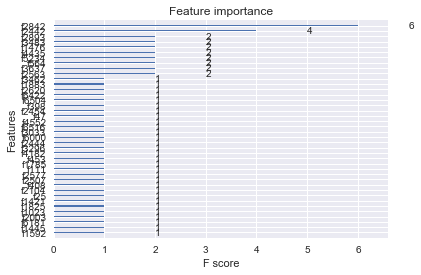

In [118]:
# Visualize feature importance (type is either weight, gain or cover)
# Deatails here: https://github.com/dmlc/xgboost/blob/2e9d06443e4793231dd9ac841f7a7879f11b1d47/python-package/xgboost/plotting.py
xgb.plot_importance(model, importance_type='weight')
plt.savefig('output/fimport.pdf')
plt.savefig('output/fimport.png')

In [119]:
def encode_prediction(y_pred, threshold=0.5):
    return 0 if y_pred < threshold else 1

# Get predictions on test set
y_true = y_test
y_pred = pd.Series([encode_prediction(y) for y in model.predict(X_test)])

# Save predictions as csv
dfp = pd.DataFrame({'predicted': y_pred})
dfp.to_csv('output/predictions.csv')

print('Confusion matrix:')
print(confusion_matrix(y_true, y_pred))

print('\nClassification report:')
print(classification_report(y_true, y_pred))

Confusion matrix:
[[ 90  12]
 [  8 290]]

Classification report:
             precision    recall  f1-score   support

          0       0.92      0.88      0.90       102
          1       0.96      0.97      0.97       298

avg / total       0.95      0.95      0.95       400



ROC AUC:
0.927753651796289


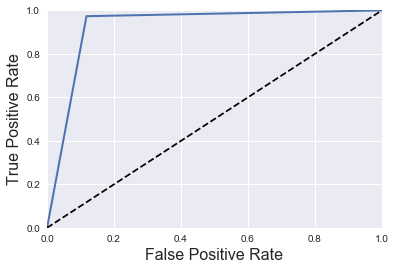

In [120]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

def plot_roc_curve(fpr, tpr, **options):
    plt.plot(fpr, tpr, linewidth=2, **options)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plot_roc_curve(fpr, tpr)

plt.savefig('output/roc_curve.pdf')
plt.savefig('output/roc_curve.png')

print('ROC AUC:')
print(roc_auc_score(y_true, y_pred))

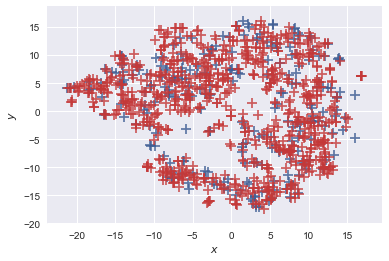

In [121]:
idx, X_train_sel = get_important_features(model, X_train)

tsne  = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=1000)
embed = tsne.fit_transform(X_train_sel)

dftsne = pd.DataFrame(embed, columns=['x', 'y'])
dftsne['label'] = y_train

label_0 = dftsne[(dftsne['label'] == 0)]
label_1 = dftsne[(dftsne['label'] == 1)]

g = sns.regplot(x='x', y='y', data=label_0, ci=None, marker="+", fit_reg=False, color="#3b5b92", scatter_kws={"s": 120})
g = sns.regplot(x='x', y='y', data=label_1, ci=None, marker="+", fit_reg=False, color="#c43838", scatter_kws={"s": 120})
g.set(xlabel='$x$', ylabel='$y$', label='t-SNE (train set)')

plt.savefig('output/t-SNE_train_set.pdf')
plt.savefig('output/t-SNE_train_set.png')

In [122]:
idx, X_test_sel = get_important_features(model, X_test)

tsne  = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=1000)
embed = tsne.fit_transform(X_test_sel)

dftsne = pd.DataFrame(embed, columns=['x', 'y'])
dftsne['label'] = y_test

label_0 = dftsne[(dftsne['label'] == 0)]
label_1 = dftsne[(dftsne['label'] == 1)]

g = sns.regplot(x='x', y='y', data=label_0, ci=None, marker="+", fit_reg=False, color="#3b5b92", scatter_kws={"s": 120})
g = sns.regplot(x='x', y='y', data=label_1, ci=None, marker="+", fit_reg=False, color="#c43838", scatter_kws={"s": 120})
g.set(xlabel='$x$', ylabel='$y$', label='t-SNE (test set)')

plt.savefig('output/t-SNE_test_set.pdf')
plt.savefig('output/t-SNE_test_set.png')

In [123]:
# Visualize the training
# def plot_tvh(tvh, best_iter, best_score=None, metric='loss', lossfunc=None, fname=None):
#     val_metric = 'val_{}'.format(metric)

#     fig, ax = plt.subplots(1, 1)
#     # tick_spacing = 1
#     # ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
#     plt.title('Evaluation results. Best score: {} Best iter: {}'.format(best_score, best_iter))
#     plt.xlabel('Iteration')
#     plt.ylabel(lossfunc)
#     plt.grid(True)
    
#     # Plot metric over number of epochs
#     xaxes = list(range(1, len(tvh[list(tvh.keys())[0]][lossfunc]) + 1))
    
#     colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k', 'w']
#     for i, key in enumerate(list(tvh.keys())):
#         plt.plot(xaxes, tvh[key][lossfunc], '{}-'.format(colors[i]), label='{set} {metric}'.format(set=key, metric=metric), linewidth=1.0)
    
#     plt.legend(loc='upper right')
#     plt.savefig(fname)
#     plt.show()
#     plt.close()
    
# lossfunc = params['eval_metric']
# plot_tvh(tvh, best_iter, best_score=best_score, lossfunc=lossfunc, fname='output/tvh.pdf')